Looking at how exactly continual learning is going on in the network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch 
import numpy as np
from PIL import Image
from torchvision import transforms
import pandas as pd 
import json 
import copy 
import pickle 
import os 
import sys
import copy
import umap
import wandb
from pytorch_lightning.loggers import WandbLogger
from types import SimpleNamespace
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('../py_scripts')
from py_scripts import LightningDataModule, get_params_net_dataloader, ModelStyles, DataSet
import glob
import pickle

/home/tbb16/anaconda3/envs/core/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
# OUTDATED: SDM model: 1cd30ndy
# SDM linear decay: 5acsdko1
# SDM no L2 norm: z69ejh56
# TopK model: 3f3fxovr
# ReLU: 14kfhln0

dataset_path="../data/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_points = 20

# this is for the pickle activation plots
data_split_or_overall = 'split' # overall

imgs_per_split = 10000

remove_dead = True
dead_threshold_activation_amount = 10

extras = dict(
    epochs_to_train_for=10,
    num_workers=1, 
    adversarial_attacks=True, 
    device=device,
    dataset_path="../data/", 
    log_metrics=False  ,
    check_val_every_n_epoch=1,
)

rand_color_map = {
    0:'red',
    1:'green',
    2:'blue',
    3:'yellow',
    4:'pink',
    5:'black',
    6:'teal',
    7:'brown',
    8:'purple',
    9:'gray',
}
# airplane, 1 automobile (but not truck or pickup truck), 2 bird, 3 cat, 4 deer, 
#5 dog, 6 frog, 7 horse, 8 ship, and truck (but not pickup truck)

def map_colors(labels):
    labels = labels.flatten()
    return [rand_color_map[int(l)] for l in labels] 

def umap_data_and_weights(data, weights,title_prefix=""):
    
    label1="Data"
    label2="Weights"
    
    reducer = umap.UMAP()  # parallel=False
    reducer.fit(weights)
    data_embedding = reducer.transform(data)
    weights_embedding = reducer.transform(weights)
    plt.figure()
    plt.scatter(data_embedding[:, 0], data_embedding[:, 1], label=label1, alpha=0.5)
    plt.scatter(weights_embedding[:, 0], weights_embedding[:, 1], label=label2, alpha=0.9)
    plt.title(f"{title_prefix} - Training Data Fit on Weights")
    plt.legend()
    
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.gcf().savefig(f'figs/EmbeddingDataOnWeights{title_prefix}.png', dpi=250)
    plt.show()
    
    reducer = umap.UMAP()  # parallel=False
    reducer.fit(data)
    data_embedding = reducer.transform(data)
    weights_embedding = reducer.transform(weights)
    plt.figure()
    plt.scatter(data_embedding[:, 0], data_embedding[:, 1], label=label1, alpha=0.5)
    plt.scatter(weights_embedding[:, 0], weights_embedding[:, 1], label=label2)
    plt.title(f"{title_prefix} - Weights Fit on Training Data")
    plt.legend()
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.gcf().savefig(f'figs/EmbeddingWeightsOnData{title_prefix}.png', dpi=250)
    plt.show()
    
    return reducer, data_embedding, weights_embedding
    
def get_weights(ckpt, params):
    if "SDM" in str(params.model_foundation):
        weights = ckpt['state_dict']['sdm_module.fc1.weight']
        out_weights = ckpt['state_dict']['sdm_module.purkinje_layer.weight']
    elif "CLASSIC_FFN" in str(params.model_foundation):
        weights = ckpt['state_dict']['fc1.weight']
        out_weights = ckpt['state_dict']['net.0.weight']
    elif "TOP_K" in str(params.model_foundation):
        weights = ckpt['state_dict']['fc1.weight']
        out_weights = ckpt['state_dict']['output_layer.weight']
    else: 
        raise NotImplementedError()
    return weights, out_weights.T

def get_activations(data, model_path, params, extras):#(data,weights, ckpt):
    
    _, model, _ = get_params_net_dataloader(params.model_style, 
                                                params.dataset, 
                                                load_from_checkpoint=model_path, 
                                                verbose=False,
                                                cont_learn_reset_output_head=False, 
                                                **extras)
    model.reload_neuron_activation_counters()
    with torch.no_grad():
        out = model.forward(data, output_model_data=True)
    logits, model_data_dict = out
    return model_data_dict['post_acts'].T
    '''if "SDM" in str(params.model_foundation):
        activations = weights@data.T
    elif "TOP_K" in str(params.model_foundation) or "CLASSIC_FFN" in str(params.model_foundation):
        activations = (weights@data.T)+ckpt['state_dict']['fc1.bias'].unsqueeze(1)
    else: 
        raise NotImplementedError()
    return activations
    '''
    
def compute_cosine_sim(m1, m2):
    return ( (m1/torch.norm(m1,keepdim=True, dim=1))*(m2/torch.norm(m2,keepdim=True, dim=1))).sum(1)

In [10]:
print_cosine = True 
print_output_weights = True 

def plot_activation_hists(model_run_ids, plot_splits=False, labels=None, bin_list=None, save_name='forgot'):

    for rind, run in enumerate(model_run_ids):

        # add the og model to the list of models. 
        src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
        model_checkpoints = glob.glob(src)
        ckpt = torch.load(model_checkpoints[0], map_location=device)
        og_model_path = "../"+ckpt['hyper_parameters']['load_from_checkpoint']

        print("===="*10)
        print("Run is:", run)
        print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])


        # sort the models. 
        models_dict = {0:og_model_path}
        for c in model_checkpoints:
            c_epoch = int(c.split('epoch=')[-1].split('-')[0])
            models_dict[c_epoch] = c
        sorted_models = list(models_dict.keys())
        sorted_models.sort()

        # get the dataset that corresponds to one of the data splits by loading in the last model. 
        # have the params from the split models too. 
        model_path = models_dict[sorted_models[-1]]
        ckpt = torch.load(model_path, map_location=device)
        params = ckpt['hyper_parameters']
        params = SimpleNamespace(**params)

        # sort the pickles. Needed to wait to load in parameters from above. 
        act_pickles = glob.glob(f'../../scratch_link/Foundational-SDM/pickles/{params.test_name}_*')
        pickles_dict = {}
        for c in act_pickles:
            c_epoch = int(c.split('Learning_')[-1].split('_')[0])
            pickles_dict[c_epoch] = c
        sorted_pickles = list(pickles_dict.keys())
        sorted_pickles.sort()
        
        if plot_splits: 
            
            for split_ind, split_interval in enumerate(split_intervals):

                pic = pickle.load(open(pickles_dict[split_interval], 'rb'))
                all_splits_frac_activated_sum = pic['split_fraction_activated'].sum(0)
                
                zeros_mask = all_splits_frac_activated_sum>0.0

                # pickles: 
                # show overall activations:
                print("Alive neurons", ((all_splits_frac_activated_sum+1e-9).log()>0).type(torch.float).mean() )
                                
                plt.hist( (all_splits_frac_activated_sum[zeros_mask]).log10(), 
                         bins=50, label=f"Split_{split_ind}",#ckpt['hyper_parameters']['test_name'], 
                         alpha=0.5, density=False)
                
            plt.legend()
            plt.title(str(labels[rind])+" - Histogram of $\log_{10}$(number) \n Each Neuron is Activated")
            plt.xlabel("$\log_{10}$(Number) of activations")
            plt.ylabel("Number of Neurons")
            plt.gcf().savefig(f'figs/{save_name}{labels[rind]}.png', dpi=250)
            plt.show()
            
        else: 
            pic = pickle.load(open(pickles_dict[sorted_pickles[-1]], 'rb'))
            
            all_splits_frac_activated_sum = pic['over_all_splits_fraction_activated'].sum(0)

            # pickles: 
            # show overall activations:
            print("Alive neurons", ((all_splits_frac_activated_sum+1e-9).log()>0).type(torch.float).mean() )
            print("Frac below Log8", torch.logical_and( (all_splits_frac_activated_sum+1e-9).log()>0, 
                                                       (all_splits_frac_activated_sum+1e-9).log()<8  ).type(torch.float).mean() )

            print("Frac below Log10", torch.logical_and( (all_splits_frac_activated_sum+1e-9).log()>0, 
                                                       (all_splits_frac_activated_sum+1e-9).log()<10  ).type(torch.float).mean() )


            zeros_mask = all_splits_frac_activated_sum>0.0

            if labels:
                label_name = labels[rind]
            else: 
                label_name = ckpt['hyper_parameters']['test_name']

            if bin_list is None: 
                bin_list = 50 
            plt.hist((all_splits_frac_activated_sum[zeros_mask]).log10(), 
                     bins=bin_list, label=label_name, 
                     alpha=0.5, density=False)


            print("===="*10)

    if not plot_splits:
        #plt.xlim(left=4)
        #plt.ylim(top=180)
        plt.legend()
        plt.title("Histogram of the $\log_{10}$(number) Each Neuron is Activated")
        plt.xlabel("$\log_{10}$(Number) of activations")
        plt.ylabel("Number of Neurons")
        plt.gcf().savefig(f'figs/{save_name}.png', dpi=250)
        plt.show()


Baseline comparisons
Run is: f2baqhx6
SDM_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.9940)
Frac below Log8 tensor(0.3370)
Frac below Log10 tensor(0.6180)
Run is: z0unvxvg
TopKDefault_Investigate_ContLearning <class 'models.FFN_TOP_K.FFN_TOP_K'>
Alive neurons tensor(0.4480)
Frac below Log8 tensor(0.0400)
Frac below Log10 tensor(0.0970)
Run is: 20runydu
ReLU_SGD_Investigate_ContLearning <class 'models.CLASSIC_FFN.CLASSIC_FFN'>
Alive neurons tensor(1.)
Frac below Log8 tensor(0.)
Frac below Log10 tensor(0.)


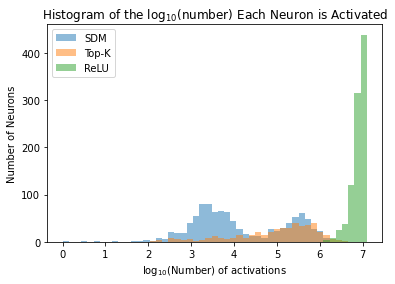

SDM comparisons
Run is: f2baqhx6
SDM_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.9940)
Frac below Log8 tensor(0.3370)
Frac below Log10 tensor(0.6180)
Run is: 3pdsnsk3
SDM_LinearDecayMask_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.9790)
Frac below Log8 tensor(0.2930)
Frac below Log10 tensor(0.5810)
Run is: 2vldgubc
SDM_NoL2Norms_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.8370)
Frac below Log8 tensor(0.3000)
Frac below Log10 tensor(0.5340)


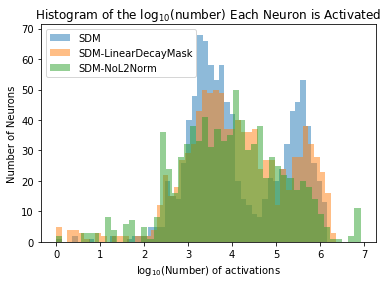

In [4]:
model_run_ids = ['f2baqhx6' ,'z0unvxvg', '20runydu', '3pdsnsk3',   '2vldgubc', ]
print("Baseline comparisons")
plot_activation_hists(['f2baqhx6','z0unvxvg', '20runydu'], 
                      labels=['SDM', 'Top-K', 'ReLU'],
                      bin_list=np.linspace(0,7.1,50),
                     save_name ='Baselines_TotalNeuronActs')
print("SDM comparisons")
plot_activation_hists(['f2baqhx6','3pdsnsk3',   '2vldgubc',], 
                      labels=['SDM', 'SDM-LinearDecayMask', 'SDM-NoL2Norm'],
                     save_name ='SDMAblates_TotalNeuronActs' )

Run is: f2baqhx6
SDM_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.9390)
Alive neurons tensor(0.8330)
Alive neurons tensor(0.7610)
Alive neurons tensor(0.8930)
Alive neurons tensor(0.7910)


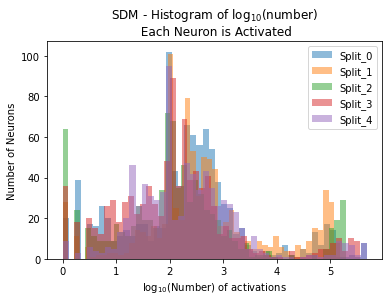

Run is: 3pdsnsk3
SDM_LinearDecayMask_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.9050)
Alive neurons tensor(0.7850)
Alive neurons tensor(0.7540)
Alive neurons tensor(0.8640)
Alive neurons tensor(0.7480)


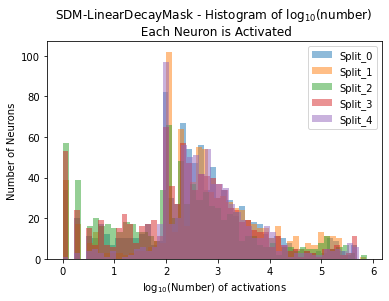

Run is: 2vldgubc
SDM_NoL2Norms_Investigate_ContLearning <class 'models.SDM.SDM'>
Alive neurons tensor(0.7420)
Alive neurons tensor(0.5530)
Alive neurons tensor(0.4960)
Alive neurons tensor(0.6420)
Alive neurons tensor(0.5780)


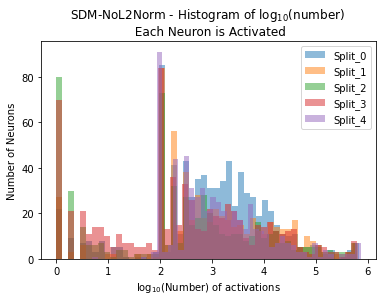

Run is: z0unvxvg
TopKDefault_Investigate_ContLearning <class 'models.FFN_TOP_K.FFN_TOP_K'>
Alive neurons tensor(0.4250)
Alive neurons tensor(0.4260)
Alive neurons tensor(0.4130)
Alive neurons tensor(0.4270)
Alive neurons tensor(0.4070)


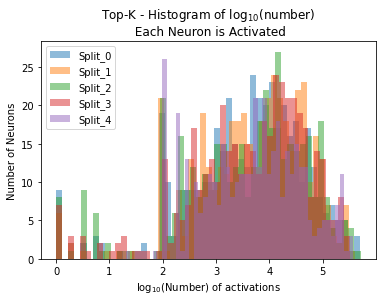

Run is: 20runydu
ReLU_SGD_Investigate_ContLearning <class 'models.CLASSIC_FFN.CLASSIC_FFN'>
Alive neurons tensor(1.)
Alive neurons tensor(1.)
Alive neurons tensor(1.)
Alive neurons tensor(1.)
Alive neurons tensor(1.)


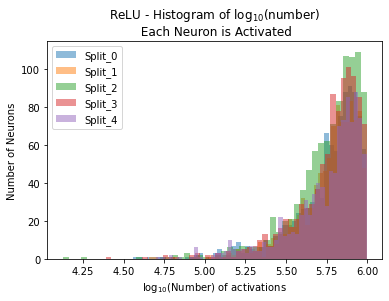

In [5]:
split_intervals =[300,600,900,1200,1400]

plot_activation_hists(['f2baqhx6','3pdsnsk3',   '2vldgubc' ,'z0unvxvg', '20runydu'],
                      plot_splits=True, 
                      labels=['SDM', 'SDM-LinearDecayMask', 'SDM-NoL2Norm', 'Top-K', 'ReLU'],
                      save_name ='_SplitNeuronActs' )

# Looking at activations per split

In [66]:
np.exp(6), np.exp(8), np.exp(11), np.exp(13)

(403.4287934927351, 2980.9579870417283, 59874.14171519782, 442413.3920089205)

# Computing the entropy of each neuron

Run is: f2baqhx6
SDM_Investigate_ContLearning <class 'models.SDM.SDM'>
../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/f2baqhx6/checkpoints/epoch=1499-step=118499.ckpt /home/tbb16/Foundational-SDM/notebooks
CHANGING OUTPUT LAYER FOR CONTINUAL LEARNING ON NEW DATASET!


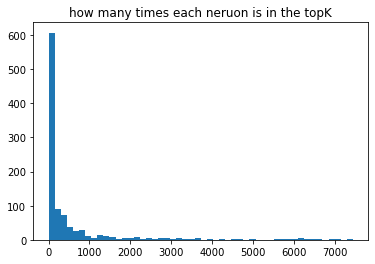

Actual K value tensor(10)


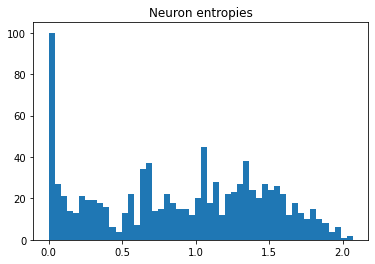

Entropies, Mean = 0.8906797170639038 and median = 0.9502705335617065
tensor(1.0000) should be 1!
Entropies weighted by number of times neuron is active
Entropies, Mean = 0.9925509095191956


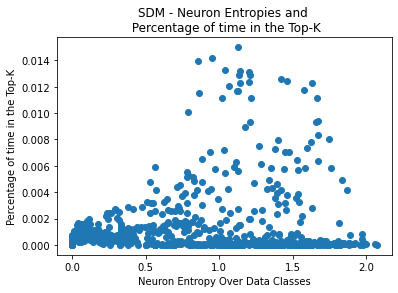

Run is: 3pdsnsk3
SDM_LinearDecayMask_Investigate_ContLearning <class 'models.SDM.SDM'>
../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/3pdsnsk3/checkpoints/epoch=1499-step=118499.ckpt /home/tbb16/Foundational-SDM/notebooks
CHANGING OUTPUT LAYER FOR CONTINUAL LEARNING ON NEW DATASET!


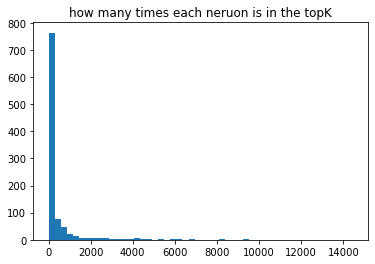

Actual K value tensor(10)


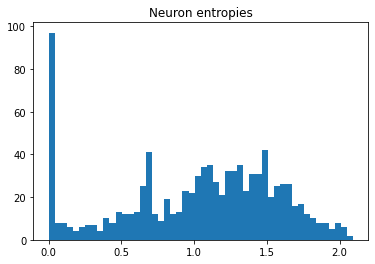

Entropies, Mean = 1.0261849164962769 and median = 1.1007966995239258
tensor(1.) should be 1!
Entropies weighted by number of times neuron is active
Entropies, Mean = 1.3380258083343506


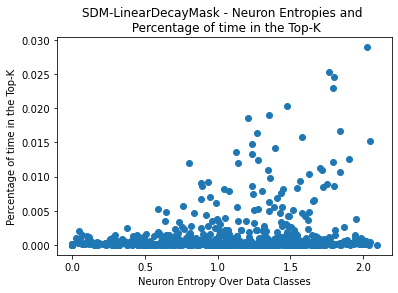

Run is: 2vldgubc
SDM_NoL2Norms_Investigate_ContLearning <class 'models.SDM.SDM'>
../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/2vldgubc/checkpoints/epoch=1499-step=118499.ckpt /home/tbb16/Foundational-SDM/notebooks
CHANGING OUTPUT LAYER FOR CONTINUAL LEARNING ON NEW DATASET!


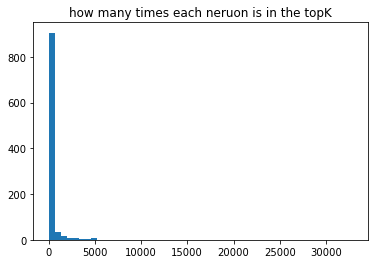

Actual K value tensor(12)


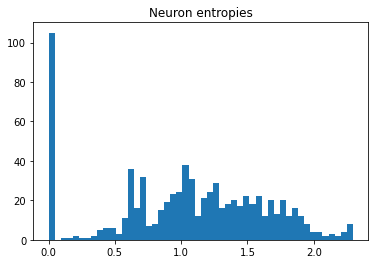

Entropies, Mean = 1.049124836921692 and median = 1.0880389213562012
tensor(1.) should be 1!
Entropies weighted by number of times neuron is active
Entropies, Mean = 1.963744044303894


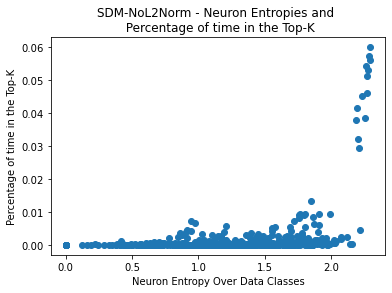

Run is: z0unvxvg
TopKDefault_Investigate_ContLearning <class 'models.FFN_TOP_K.FFN_TOP_K'>
../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/z0unvxvg/checkpoints/epoch=1499-step=118499.ckpt /home/tbb16/Foundational-SDM/notebooks
CHANGING OUTPUT LAYER FOR CONTINUAL LEARNING ON NEW DATASET!


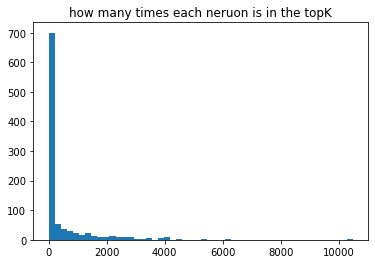

Actual K value tensor(10)


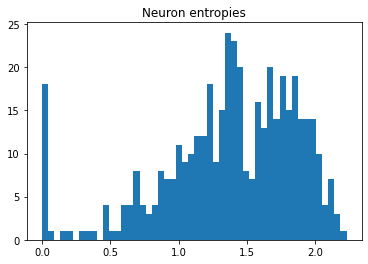

Entropies, Mean = 1.3770031929016113 and median = 1.4209970235824585
tensor(1.0000) should be 1!
Entropies weighted by number of times neuron is active
Entropies, Mean = 1.4818395376205444


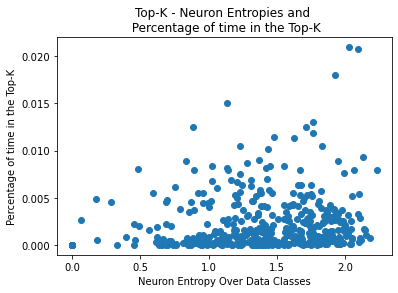

Run is: 20runydu
ReLU_SGD_Investigate_ContLearning <class 'models.CLASSIC_FFN.CLASSIC_FFN'>
../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/20runydu/checkpoints/epoch=1499-step=118499.ckpt /home/tbb16/Foundational-SDM/notebooks
CHANGING OUTPUT LAYER FOR CONTINUAL LEARNING ON NEW DATASET!


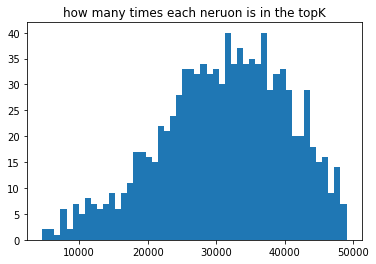

Actual K value tensor(578)


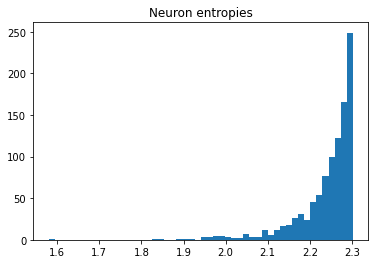

Entropies, Mean = 2.240032196044922 and median = 2.2635016441345215
tensor(1.0000) should be 1!
Entropies weighted by number of times neuron is active
Entropies, Mean = 2.2560951709747314


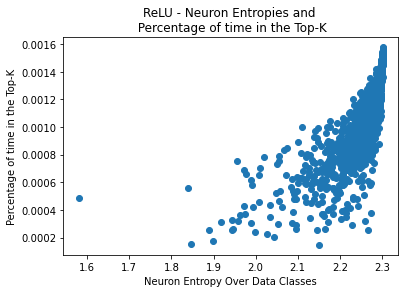

In [8]:

def compute_neuron_entropies(runs, labels, save_name):
    #entropies_dict = dict()
    for rind, run in enumerate(runs): 
        
        # add the og model to the list of models. 
        src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
        model_checkpoints = glob.glob(src)
        ckpt = torch.load(model_checkpoints[0], map_location=device)
        og_model_path = "../"+ckpt['hyper_parameters']['load_from_checkpoint']

        print("===="*10)
        print("Run is:", run)
        print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])
        print("===="*10)

        # sort the models. 
        models_dict = {0:og_model_path}
        for c in model_checkpoints:
            c_epoch = int(c.split('epoch=')[-1].split('-')[0])
            models_dict[c_epoch] = c
        sorted_models = list(models_dict.keys())
        sorted_models.sort()

        # load in the original model weights
        og_ckpt = torch.load(og_model_path, map_location=device)
        og_params = og_ckpt['hyper_parameters']
        og_params = SimpleNamespace(**og_params)
        #og_params.dataset = DataSet.Cached_ConvMixer_ImageNet32
        og_weights, og_out_weights = get_weights(og_ckpt, og_params)
        og_out_weights = og_out_weights[:,:10]

        # get the dataset that corresponds to one of the data splits by loading in the last model. 
        # have the params from the split models too. 
        model_path = models_dict[sorted_models[-1]]
        ckpt = torch.load(model_path, map_location=device)
        params = ckpt['hyper_parameters']
        params = SimpleNamespace(**params)
        last_model_weights, last_model_out_weights = get_weights(ckpt, params)
        
        data_module = LightningDataModule(
        params,
        data_path=dataset_path
            )
        data_module.setup(None, train_shuffle=False, test_shuffle=False)

        # sort the pickles. Needed to wait to load in parameters from above. 
        act_pickles = glob.glob(f'../../scratch_link/Foundational-SDM/pickles/{params.test_name}_*')
        pickles_dict = {}
        for c in act_pickles:
            c_epoch = int(c.split('Learning_')[-1].split('_')[0])
            pickles_dict[c_epoch] = c
        sorted_pickles = list(pickles_dict.keys())
        sorted_pickles.sort()

        all_data = torch.stack( [d.images for d in data_module.train_datasets]).flatten(end_dim=1)
        all_labels = torch.stack( [d.img_labels for d in data_module.train_datasets]).flatten(end_dim=1)

        # ensure that weights and data are L2 normed if it is SDM!
        if "SDM" in str(params.model_foundation) and params.norm_addresses:
            all_data = all_data/torch.norm(all_data, dim=1, keepdim=True)

        if use_og_model:
            # looking at activations using the original weights not the final ones. 
            activations = get_activations(all_data, og_model_path, og_params, extras) #get_activations(all_data,og_weights, ckpt)
        else: 
            activations = get_activations(all_data, model_path, params, extras) #get_activations(all_data,og_weights, ckpt)

        plt.hist((activations>0.000001).type(torch.float).sum(1), bins=50)
        plt.title("how many times each neruon is in the topK")
        plt.show()
        
        # get the entropy for each neuron? 
        in_top_k_per_label = torch.zeros((1000,10))
        for l in range(10):
            label_mask = all_labels==l
            num_times_active_in_label = (activations[:, label_mask]>0.001).type(torch.float).sum(1)
            in_top_k_per_label[:,l] = num_times_active_in_label
            
        print("Actual K value", (activations[:, 0]>0.0001).sum())
            
        act_mask = in_top_k_per_label.sum(1)>0.0000001
        
        act_pdf = in_top_k_per_label[act_mask] / in_top_k_per_label[act_mask].sum(1,keepdim=True)

        z_inds = act_pdf == 0.0
        act_pdf[z_inds] += 1e-15
        data_ent = -(act_pdf * torch.log(act_pdf)).sum(1)
        
        plt.hist(data_ent, bins=50)
        plt.title("Neuron entropies")
        plt.show()
        
        print(f"Entropies, Mean = {data_ent.mean()} and median = {np.median(data_ent.numpy())}")
        
        perc_contributing = in_top_k_per_label[act_mask].sum(1) / in_top_k_per_label[act_mask].sum()
        print(perc_contributing.sum(), 'should be 1!')
        print("Entropies weighted by number of times neuron is active")
        print(f"Entropies, Mean = { (perc_contributing*data_ent).sum()}")#" and median = {np.median((perc_contributing*data_ent).numpy())}")

        plt.scatter( data_ent ,perc_contributing)
        plt.title(f"{labels[rind]} - Neuron Entropies and \n Percentage of time in the Top-K")
        plt.xlabel("Neuron Entropy Over Data Classes")
        plt.ylabel("Percentage of time in the Top-K")
        plt.gcf().savefig(f'figs/{save_name}{labels[rind]}.png', dpi=250)
        plt.show()
        
use_og_model = False # otherwise will use last model
compute_neuron_entropies(['f2baqhx6','3pdsnsk3',   '2vldgubc' ,'z0unvxvg', '20runydu'], 
                         ['SDM', 'SDM-LinearDecayMask', 'SDM-NoL2Norm', 'Top-K', 'ReLU'], 
                         "EntropyScatter_")

# Neuron Data Manifolds and How many Times each neuron was activated

In [3]:
def compute_neuron_manifolds(runs, labels, save_name):
    #entropies_dict = dict()
    for rind, run in enumerate(runs): 

        # add the og model to the list of models. 
        src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
        model_checkpoints = glob.glob(src)
        ckpt = torch.load(model_checkpoints[0], map_location=device)
        og_model_path = "../"+ckpt['hyper_parameters']['load_from_checkpoint']

        print("===="*10)
        print("Run is:", run)
        print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])
        print("===="*10)

        # sort the models. 
        models_dict = {0:og_model_path}
        for c in model_checkpoints:
            c_epoch = int(c.split('epoch=')[-1].split('-')[0])
            models_dict[c_epoch] = c
        sorted_models = list(models_dict.keys())
        sorted_models.sort()

        # load in the original model weights
        og_ckpt = torch.load(og_model_path, map_location=device)
        og_params = og_ckpt['hyper_parameters']
        og_params = SimpleNamespace(**og_params)
        #og_params.dataset = DataSet.Cached_ConvMixer_ImageNet32
        og_weights, og_out_weights = get_weights(og_ckpt, og_params)
        og_out_weights = og_out_weights[:,:10]

        # get the dataset that corresponds to one of the data splits by loading in the last model. 
        # have the params from the split models too. 
        model_path = models_dict[sorted_models[-1]]
        ckpt = torch.load(model_path, map_location=device)
        params = ckpt['hyper_parameters']
        params = SimpleNamespace(**params)
        last_model_weights, last_model_out_weights = get_weights(ckpt, params)
        data_module = LightningDataModule(
                params,
                data_path=dataset_path
            )
        data_module.setup(None, train_shuffle=False, test_shuffle=False)

        # sort the pickles. Needed to wait to load in parameters from above. 
        act_pickles = glob.glob(f'../../scratch_link/Foundational-SDM/pickles/{params.test_name}_*')
        pickles_dict = {}
        for c in act_pickles:
            c_epoch = int(c.split('Learning_')[-1].split('_')[0])
            pickles_dict[c_epoch] = c
        sorted_pickles = list(pickles_dict.keys())
        sorted_pickles.sort()

        all_data = torch.stack( [d.images for d in data_module.train_datasets]).flatten(end_dim=1)
        all_labels = torch.stack( [d.img_labels for d in data_module.train_datasets]).flatten(end_dim=1)

        # ensure that weights and data are L2 normed if it is SDM!
        if "SDM" in str(params.model_foundation) and params.norm_addresses:
            all_data = all_data/torch.norm(all_data, dim=1, keepdim=True)

        # fit on the weights first
        reducer, all_data_embedding, og_weight_embedding = umap_data_and_weights(all_data, og_weights, title_prefix=f"{labels[rind]}")

        # looking at activations using the original weights not the final ones. 
        activations = get_activations(all_data, og_model_path, og_params, extras) #get_activations(all_data,og_weights, ckpt)

        vals, inds = activations.max(dim=1)
        max_act_classes = all_labels[inds]

        plt.figure()
        plt.scatter(all_data_embedding[:, 0], all_data_embedding[:, 1], 
                c=map_colors(all_labels), alpha=0.1)
        plt.title(f"{labels[rind]} - Training Data Manifold by Class")
        plt.xlabel("UMAP Dim 1")
        plt.ylabel("UMAP Dim 2")
        plt.gcf().savefig(f'figs/{save_name}TrainingData{labels[rind]}.png', dpi=250)
        plt.show()

        

        # which neurons are activated over the course of training: 
        # last pickle that has all the neuron activation amounts. 
        # should I also be storing the gradients? 
        pic = pickle.load(open(pickles_dict[sorted_pickles[-1]], 'rb'))
        all_splits_frac_activated_sum = pic['over_all_splits_fraction_activated'].sum(0)

        # removing dead neurons
        full_act_weights_mask = all_splits_frac_activated_sum>dead_threshold_activation_amount
        print("Perc alive neurons", full_act_weights_mask.type(torch.float).mean())
        live_og_weight_embedding = og_weight_embedding[full_act_weights_mask]
        live_max_act_classes = max_act_classes[full_act_weights_mask]
        live_all_splits_frac_activated_sum = all_splits_frac_activated_sum[full_act_weights_mask]

        plt.figure()
        plt.scatter(live_og_weight_embedding[:, 0], live_og_weight_embedding[:, 1], 
                c=map_colors(live_max_act_classes))
        plt.title(f"{labels[rind]} - Alive Neurons Most Activating Class")
        plt.xlabel("UMAP Dim 1")
        plt.ylabel("UMAP Dim 2")
        plt.gcf().savefig(f'figs/{save_name}NeuronClassMap{labels[rind]}.png', dpi=250)
        plt.show()


        plt.figure()
        plt.scatter(live_og_weight_embedding[:, 0], live_og_weight_embedding[:, 1], 
                c=live_all_splits_frac_activated_sum, 
                alpha=1)
        
        plt.title(f"{labels[rind]} - Number of Times \n each Neuron is Activated")
        plt.xlabel("UMAP Dim 1")
        plt.ylabel("UMAP Dim 2")
        plt.gcf().savefig(f'figs/{save_name}NeuronActivationMap{labels[rind]}.png', dpi=250)
        plt.show()

        
compute_neuron_manifolds(['f2baqhx6','3pdsnsk3',   '2vldgubc' ,'z0unvxvg', '20runydu'], 
                         ['SDM', 'SDM-LinearDecayMask', 'SDM-NoL2Norm', 'Top-K', 'ReLU'], 
                         "NeuronManifold_")

Run is: f2baqhx6
SDM_Investigate_ContLearning <class 'models.SDM.SDM'>


KeyboardInterrupt: 

In [10]:
sorted_models

[999]

# Getting images of the exact weights and nearby training data

Run is: 2l9qc5ot
SDM_SGDM_lr=0.03_NegWeights_NiceReceptiveFields_10MSwitch_RawCIFAR_StaleGradients_Longer <class 'models.SDM.SDM'>


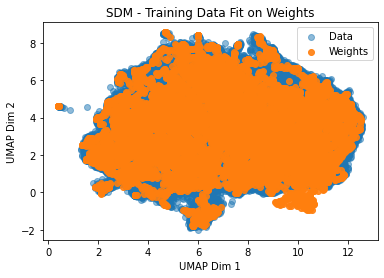

In [31]:
runs, labels, save_name = ['2l9qc5ot'],  ['SDM',], "NeuronVisManifold_"
#entropies_dict = dict()
for rind, run in enumerate(runs): 

    # add the og model to the list of models. 
    src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
    model_checkpoints = glob.glob(src)
    ckpt = torch.load(model_checkpoints[0], map_location=device)
    print("===="*10)
    print("Run is:", run)
    print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])
    print("===="*10)

    # sort the models. 
    models_dict = {}
    for c in model_checkpoints:
        c_epoch = int(c.split('epoch=')[-1].split('-')[0])
        models_dict[c_epoch] = c
    sorted_models = list(models_dict.keys())
    sorted_models.sort()
    
    model_path = models_dict[sorted_models[-1]]

    # load in the original model weights
    og_ckpt = torch.load(model_path, map_location=device)
    og_params = og_ckpt['hyper_parameters']
    og_params = SimpleNamespace(**og_params)
    #og_params.dataset = DataSet.Cached_ConvMixer_ImageNet32
    og_weights, og_out_weights = get_weights(og_ckpt, og_params)
    og_out_weights = og_out_weights[:,:10]

    # get the dataset that corresponds to one of the data splits by loading in the last model. 
    # have the params from the split models too. 
    
    ckpt = og_ckpt
    params = ckpt['hyper_parameters']
    params = SimpleNamespace(**params)
    last_model_weights, last_model_out_weights = get_weights(ckpt, params)
    data_module = LightningDataModule(
            params,
            data_path=dataset_path+params.dataset_path_suffix
        )
    data_module.setup(None, train_shuffle=False, test_shuffle=False)

    all_data = data_module.train_data.images
    all_labels = data_module.train_data.img_labels
    
    if all_data.dtype is torch.uint8:#"/ImageNet32/" in self.dataset_path or "/CIFAR10/" in self.dataset_path:
            all_data = all_data.type(torch.float)/255
    all_data = all_data.flatten(start_dim=1)

    # ensure that weights and data are L2 normed if it is SDM!
    if "SDM" in str(params.model_foundation) and params.norm_addresses:
        all_data = all_data/torch.norm(all_data, dim=1, keepdim=True)

    ######

    label1="Data"
    label2="Weights"

    reducer = umap.UMAP()  # parallel=False
    reducer.fit(og_weights)
    data_embedding = reducer.transform(all_data)
    weights_embedding = reducer.transform(og_weights)
    plt.figure()
    plt.scatter(data_embedding[:, 0], data_embedding[:, 1], label=label1, alpha=0.5)
    plt.scatter(weights_embedding[:, 0], weights_embedding[:, 1], label=label2, alpha=0.6)
    plt.title(f"{labels[rind]} - Training Data Fit on Weights")
    plt.legend()

    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    #plt.gcf().savefig(f'figs/EmbeddingDataOnWeights{title_prefix}.png', dpi=250)
    plt.show()

    #######


In [176]:
def imshow(img, title="No Title Given", save_name=None):
    img = img-img.min()
    img = img*( 1/ img.max() )
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    if save_name: 
        plt.gcf().savefig(f'figs/{save_name}.png', dpi=250)
        
    plt.show()
    
def modify_weights(img):
    img = img-img.min()
    img = img*( 1/ img.max() )
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))
    

In [ ]:
imgd=32
for wind in np.random.choice(10000, 10): # 4409 # 3733 # 2963 # 5385
    imshow(og_weights[wind].reshape(3, imgd, imgd), f"Neuron {wind}")

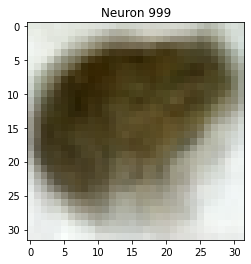

In [178]:
wind = 999 # 999 # 5345
imgd=32
imshow(og_weights[wind].reshape(3, imgd, imgd), f"Neuron {wind}", f"fullImage{wind}")


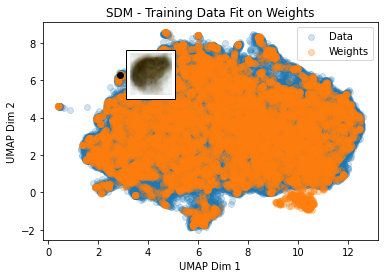

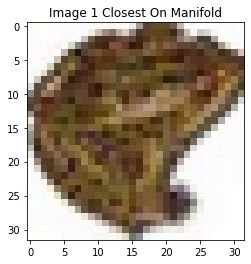

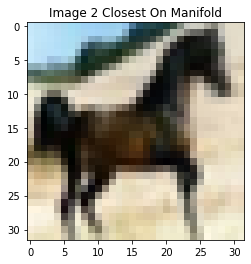

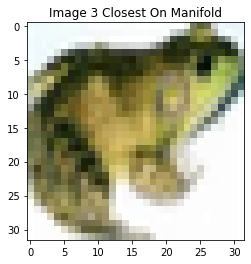

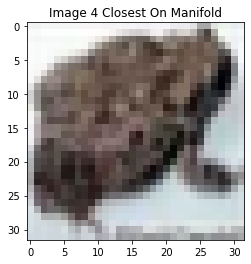

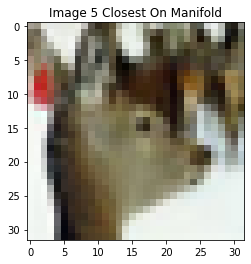

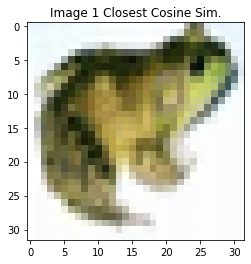

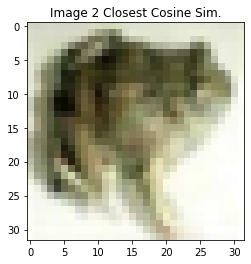

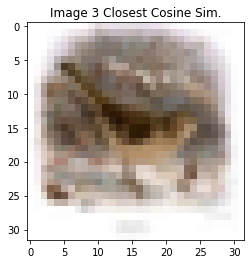

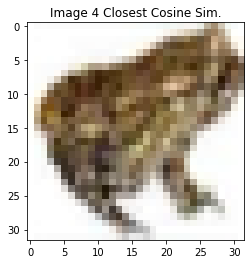

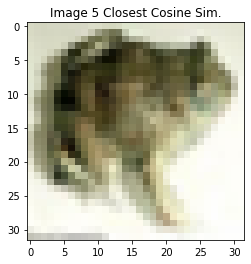

In [177]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

xshift = 1.2
kval=5

plt.figure()
plt.scatter(data_embedding[:, 0], data_embedding[:, 1], label=label1, alpha=0.2)
plt.scatter(weights_embedding[:, 0], weights_embedding[:, 1], label=label2, alpha=0.3)

ax = plt.gca()
    
xshift = 1.2
dendrites = og_weights[wind, :]
embed_loc = weights_embedding[wind, :]
plt.scatter(embed_loc[0], embed_loc[1], c="black")
im = OffsetImage( modify_weights(dendrites.reshape((3, imgd, imgd)) ), zoom=1.3)
ab = AnnotationBbox(
    im, (embed_loc[0] + xshift, embed_loc[1]), xycoords="data", frameon=True
)
ax.add_artist(ab)
ax.update_datalim(np.column_stack([embed_loc[0], embed_loc[1]]))
ax.autoscale()
    
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.title(f"{labels[rind]} - Training Data Fit on Weights")
plt.legend()
plt.gcf().savefig(f'figs/wind={wind}EmbeddingDataOnWeights-SDM.png', dpi=250)
plt.show()


# get nearby data points on the embedding

shift_shifter=0.5
shift_scaler = 5
inds = np.argsort( ( (data_embedding-weights_embedding[wind])**2 ).sum(axis=1) )[:kval] 
#_, inds = torch.topk(activations, kval)
for iind, dind in enumerate(inds): 
    xshift = np.random.random()*shift_scaler +shift_shifter
    yshift = -np.random.random()*shift_scaler -shift_shifter
    if np.random.random()<0.5:
        xshift = -xshift
    #if np.random.random()<0.5:
    #    yshift = -yshift
    dendrites = all_data[dind, :]
    embed_loc = data_embedding[dind, :]
    #plt.scatter(embed_loc[0], embed_loc[1], c="red")
    imshow(dendrites.reshape((3, imgd, imgd)), f"Image {iind+1} Closest On Manifold", 
          f"wind={wind}ManifoldClosest{iind}.png")
    '''im = OffsetImage( modify_weights(dendrites.reshape((3, imgd, imgd)) ), zoom=1.0)
    ab = AnnotationBbox(
        im, (embed_loc[0] + xshift, embed_loc[1]+yshift), xycoords="data", frameon=False
    )
    ax.add_artist(ab)
    ax.update_datalim(np.column_stack([embed_loc[0], embed_loc[1]]))
    ax.autoscale()'''

    
# get nearby data points via activation
activations = all_data@og_weights[wind, :]

shift_shifter=0.5
shift_scaler = 5
#inds = np.argsort( ( (data_embedding-weights_embedding[wind])**2 ).sum(axis=1) )[:kval] 
_, inds = torch.topk(activations, kval)
for iind, dind in enumerate(inds): 
    xshift = np.random.random()*shift_scaler +shift_shifter
    yshift = -np.random.random()*shift_scaler -shift_shifter
    if np.random.random()<0.5:
        xshift = -xshift
    #if np.random.random()<0.5:
    #    yshift = -yshift
    dendrites = all_data[dind, :]
    embed_loc = data_embedding[dind, :]
    #plt.scatter(embed_loc[0], embed_loc[1], c="red")
    imshow(dendrites.reshape((3, imgd, imgd)), f"Image {iind+1} Closest Cosine Sim.", 
               f"wind={wind}MostActive{iind}.png" )
    



# Comparing how much the output weights update over time

# Looking at No L2 norm activation activity

In [97]:
# Looking at how active each of the no L2 norm values actually are

run = '2vldgubc'

# add the og model to the list of models. 
src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
model_checkpoints = glob.glob(src)
ckpt = torch.load(model_checkpoints[0], map_location=device)
og_model_path = "../"+ckpt['hyper_parameters']['load_from_checkpoint']

print("===="*10)
print("Run is:", run)
print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])
print("===="*10)

# sort the models. 
models_dict = {0:og_model_path}
for c in model_checkpoints:
    c_epoch = int(c.split('epoch=')[-1].split('-')[0])
    models_dict[c_epoch] = c
sorted_models = list(models_dict.keys())
sorted_models.sort()

# load in the original model weights
og_ckpt = torch.load(og_model_path, map_location=device)
og_params = og_ckpt['hyper_parameters']
og_params = SimpleNamespace(**og_params)
#og_params.dataset = DataSet.Cached_ConvMixer_ImageNet32
og_weights, og_out_weights = get_weights(og_ckpt, og_params)
og_out_weights = og_out_weights[:,:10]

# get the dataset that corresponds to one of the data splits by loading in the last model. 
# have the params from the split models too. 
model_path = models_dict[sorted_models[-1]]
ckpt = torch.load(model_path, map_location=device)
params = ckpt['hyper_parameters']
params = SimpleNamespace(**params)
last_model_weights, last_model_out_weights = get_weights(ckpt, params)

Run is: 2vldgubc
SDM_NoL2Norms_Investigate_ContLearning <class 'models.SDM.SDM'>


In [98]:
data_module = LightningDataModule(
        params,
        data_path=dataset_path
    )
data_module.setup(None, train_shuffle=False, test_shuffle=False)

# sort the pickles. Needed to wait to load in parameters from above. 
act_pickles = glob.glob(f'../../scratch_link/Foundational-SDM/pickles/{params.test_name}_*')
pickles_dict = {}
for c in act_pickles:
    c_epoch = int(c.split('Learning_')[-1].split('_')[0])
    pickles_dict[c_epoch] = c
sorted_pickles = list(pickles_dict.keys())
sorted_pickles.sort()

all_data = torch.stack( [d.images for d in data_module.train_datasets]).flatten(end_dim=1)
all_labels = torch.stack( [d.img_labels for d in data_module.train_datasets]).flatten(end_dim=1)

# ensure that weights and data are L2 normed if it is SDM!
if "SDM" in str(params.model_foundation) and params.norm_addresses:
    all_data = all_data/torch.norm(all_data, dim=1, keepdim=True)

# looking at activations using the original weights not the final ones. 
activations = get_activations(all_data, og_model_path, og_params, extras) #get_activations(all_data,og_weights, ckpt)

../experiments/ConvMixer_ImageNet32_ImageNet32_ContLearnStarters/SDM_NoL2Norms_ContinualLearningPretrains_ConvMixer_WTransforms_ImageNet32_ImageNet32 /home/tbb16/Foundational-SDM/notebooks


In [99]:
val_all_data = torch.stack( [d.images for d in data_module.test_datasets]).flatten(end_dim=1)
val_all_labels = torch.stack( [d.img_labels for d in data_module.test_datasets]).flatten(end_dim=1)

# looking at activations using the original weights not the final ones. 
val_activations = get_activations(val_all_data, og_model_path, og_params, extras) #get_activations(all_data,og_weights, ckpt)

../experiments/ConvMixer_ImageNet32_ImageNet32_ContLearnStarters/SDM_NoL2Norms_ContinualLearningPretrains_ConvMixer_WTransforms_ImageNet32_ImageNet32 /home/tbb16/Foundational-SDM/notebooks


In [104]:
print("Number of alive neurons. Train Dataset", (activations.sum(1)>dead_threshold_activation_amount).type(torch.float).mean() )
print("Number of alive neurons. Val Dataset", (val_activations.sum(1)>dead_threshold_activation_amount).type(torch.float).mean() )

Number of alive neurons. Train Dataset tensor(0.5290)
Number of alive neurons. Val Dataset tensor(0.3590)


Text(0.5, 1.0, 'how many times each neruon is in the topK')

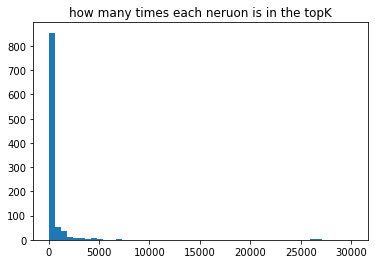

In [115]:
# how many times each neruon is in the topK
plt.hist((activations>0.001).type(torch.float).sum(1), bins=50)
plt.title("how many times each neruon is in the topK")

In [128]:
# get the entropy for each neuron? 
in_top_k_per_label = torch.zeros((1000,10))
for l in range(10):
    label_mask = all_labels==l
    num_times_active_in_label = (activations[:, label_mask]>0.001).type(torch.float).sum(1)
    in_top_k_per_label[:,l] = num_times_active_in_label
in_top_k_per_label.sum()


tensor(550000.)

In [132]:
in_top_k_per_label[0].sum()

tensor(0.)

In [160]:
(in_top_k_per_label.sum(1)>0.01).sum()

tensor(447)

In [161]:
act_mask = in_top_k_per_label.sum(1)>0.01

In [169]:
act_pdf = in_top_k_per_label[act_mask] / in_top_k_per_label[act_mask].sum(1,keepdim=True)

z_inds = act_pdf == 0.0
act_pdf[z_inds] += 1e-15
data_ent = -(act_pdf * torch.log(act_pdf)).sum(1)
data_ent.shape

torch.Size([447])

In [170]:
in_top_k_per_label[act_mask][4]

tensor([0., 0., 8., 1., 2., 0., 5., 0., 0., 0.])

In [171]:
data_ent

tensor([1.9726e+00, 1.8054e+00, 1.0553e+00, 1.1052e+00, 1.1433e+00, 1.6387e+00,
        1.1944e+00, 1.3552e+00, 1.4193e+00, 4.8754e-01, 1.2183e+00, 1.0493e+00,
        1.7829e+00, 8.4565e-01, 1.6993e+00, 1.7146e+00, 1.2760e+00, 1.0709e+00,
        1.6768e+00, 1.3363e+00, 1.7063e+00, 1.2830e+00, 5.9307e-01, 1.5548e+00,
        1.4300e+00, 2.0842e+00, 2.1154e+00, 1.8755e+00, 1.1366e+00, 3.1085e-13,
        1.6826e+00, 1.2770e+00, 1.3578e+00, 7.7112e-01, 2.4202e-01, 5.8928e-01,
        1.9268e+00, 2.1809e+00, 1.9403e+00, 1.8651e+00, 1.9972e+00, 1.9103e+00,
        1.4339e+00, 1.5942e+00, 4.0368e-01, 1.1985e+00, 4.7454e-01, 1.1112e+00,
        2.1496e+00, 1.7135e+00, 1.5182e+00, 1.1480e+00, 1.3304e+00, 1.4224e+00,
        8.8669e-01, 1.4501e+00, 9.0005e-01, 1.8620e+00, 3.1085e-13, 1.8318e+00,
        1.7743e+00, 1.5267e+00, 1.3796e+00, 1.4965e+00, 1.0453e+00, 1.1327e+00,
        1.7273e+00, 1.7605e+00, 1.4402e+00, 1.4328e+00, 1.9294e+00, 9.0519e-01,
        1.3701e+00, 1.0986e+00, 1.5051e+

In [176]:
nan_mask = ~torch.isnan(data_ent)
data_ent[nan_mask].shape

torch.Size([447])

(array([16.,  1.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  2.,  2.,  2.,  3.,
         3.,  6.,  2.,  4.,  3.,  4.,  6.,  5.,  9.,  9., 14.,  9., 16.,
         8.,  9., 12., 24., 24., 21., 17., 15.,  9., 11., 19., 15., 20.,
        15., 14., 16., 14., 17., 18.,  5.,  7., 12.,  4.,  1.]),
 array([3.1084900e-13, 4.4694252e-02, 8.9388505e-02, 1.3408275e-01,
        1.7877701e-01, 2.2347125e-01, 2.6816550e-01, 3.1285977e-01,
        3.5755402e-01, 4.0224826e-01, 4.4694251e-01, 4.9163678e-01,
        5.3633100e-01, 5.8102530e-01, 6.2571955e-01, 6.7041379e-01,
        7.1510804e-01, 7.5980228e-01, 8.0449653e-01, 8.4919077e-01,
        8.9388502e-01, 9.3857932e-01, 9.8327357e-01, 1.0279678e+00,
        1.0726620e+00, 1.1173563e+00, 1.1620506e+00, 1.2067448e+00,
        1.2514391e+00, 1.2961333e+00, 1.3408276e+00, 1.3855218e+00,
        1.4302161e+00, 1.4749103e+00, 1.5196046e+00, 1.5642989e+00,
        1.6089931e+00, 1.6536874e+00, 1.6983815e+00, 1.7430758e+00,
        1.7877700e+00, 1.8324643e+00

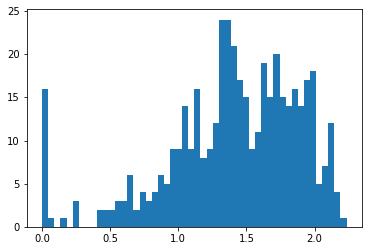

In [177]:
plt.hist(data_ent, bins=50)

In [178]:
m_in_top_k_per_label = in_top_k_per_label[act_mask]
m_in_top_k_per_label[torch.argmax(data_ent).item()]

tensor([337., 187., 593., 522., 646., 408., 524., 528., 188., 376.])

<BarContainer object of 10 artists>

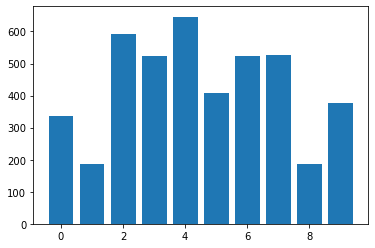

In [179]:
plt.bar(np.arange(10), m_in_top_k_per_label[torch.argmax(data_ent).item()])

In [180]:
m_in_top_k_per_label = in_top_k_per_label[act_mask]
m_in_top_k_per_label[torch.argmin(data_ent).item()]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

<BarContainer object of 10 artists>

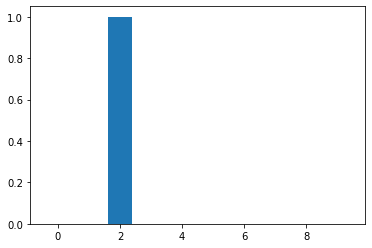

In [181]:
plt.bar(np.arange(10), m_in_top_k_per_label[torch.argmin(data_ent).item()])

In [127]:
(activations[:, 0]>0.001).type(torch.float).sum()

tensor(11.)

In [126]:
num_times_active_in_label.shape

torch.Size([1000])

In [121]:
label_mask = all_labels==0
activations[:, label_mask].shape

torch.Size([1000, 5000])

(array([705.,  62.,  32.,  38.,  18.,  19.,  17.,  17.,  12.,  14.,  11.,
          5.,  11.,   3.,   4.,   5.,   2.,   1.,   3.,   4.,   2.,   4.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([    0.  ,   252.88,   505.76,   758.64,  1011.52,  1264.4 ,
         1517.28,  1770.16,  2023.04,  2275.92,  2528.8 ,  2781.68,
         3034.56,  3287.44,  3540.32,  3793.2 ,  4046.08,  4298.96,
         4551.84,  4804.72,  5057.6 ,  5310.48,  5563.36,  5816.24,
         6069.12,  6322.  ,  6574.88,  6827.76,  7080.64,  7333.52,
         7586.4 ,  7839.28,  8092.16,  8345.04,  8597.92,  8850.8 ,
         9103.68,  9356.56,  9609.44,  9862.32, 10115.2 , 10368.08,
        10620.96, 10873.84, 11126.72, 11379.6 , 11632.48, 11885.36,
        12138.24, 12391.12, 12644.  ], dtype=float32),
 <a list of 50 Patch objects>)

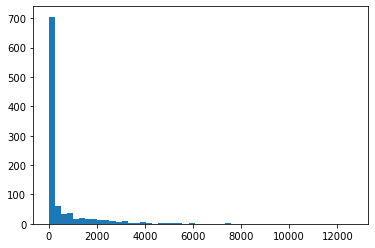

In [120]:
# there are a number of neurons that are in half or 10% of all activations. 

plt.hist((activations>0.001).type(torch.float).sum(1), bins=50)

In [105]:
vals, inds = activations.max(dim=1)
max_act_classes = all_labels[inds]
inds[0], vals[0:5] # it is the same for all of them

(tensor(41705), tensor([3.6419, 0.2530, 1.6600, 3.5051, 4.1677]))

Text(0.5, 1.0, 'Specific Neuron Activation')

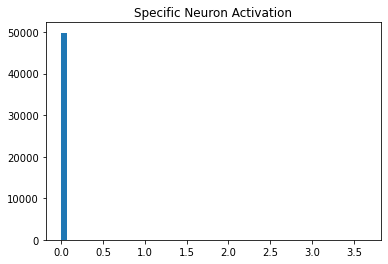

In [106]:
plt.hist(activations[0],bins=50)
plt.title("Specific Neuron Activation")

Text(0.5, 1.0, 'All activations')

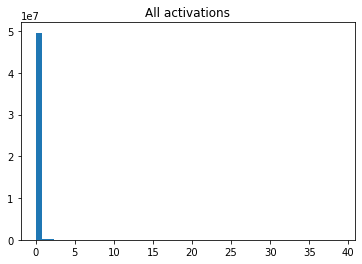

In [107]:
plt.hist(activations.flatten(),bins=50)
plt.title("All activations")

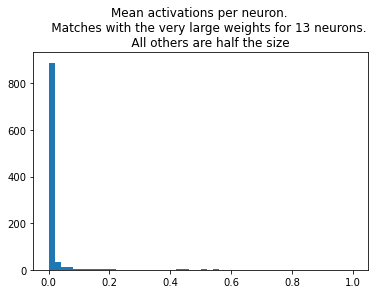

In [108]:
plt.hist(activations.mean(1),bins=50)
plt.title("Mean activations per neuron. \n \
    Matches with the very large weights for 13 neurons. \n \
    All others are half the size")
plt.show()

(array([714.,  61.,  35.,  33.,  23.,  19.,  17.,   9.,  14.,  12.,  10.,
         12.,   3.,   3.,   5.,   4.,   2.,   3.,   2.,   2.,   2.,   2.,
          2.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.0213508 , 0.0427016 , 0.0640524 , 0.0854032 ,
        0.10675399, 0.12810479, 0.14945559, 0.1708064 , 0.1921572 ,
        0.21350798, 0.23485878, 0.25620958, 0.27756038, 0.29891118,
        0.32026199, 0.3416128 , 0.3629636 , 0.3843144 , 0.40566516,
        0.42701596, 0.44836676, 0.46971756, 0.49106836, 0.51241916,
        0.53376997, 0.55512077, 0.57647157, 0.59782237, 0.61917317,
        0.64052397, 0.6618748 , 0.6832256 , 0.7045764 , 0.7259272 ,
        0.747278  , 0.7686288 , 0.7899796 , 0.8113303 , 0.8326811 ,
        0.8540319 , 0.8753827 , 0.8967335 , 0.9180843 , 0.9394351 ,
        0.9607859 , 0.9821367 , 1.0034876 , 1.

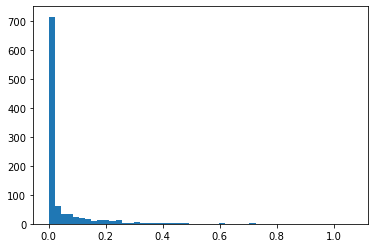

In [119]:
plt.hist(activations.mean(1),bins=50)

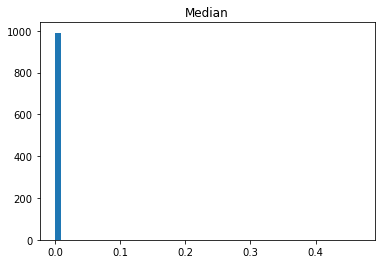

In [109]:
plt.hist(np.median(activations.numpy(),axis=1),bins=50)
plt.title("Median")
plt.show()

(array([888.,  35.,  12.,  12.,   5.,   5.,   4.,   5.,   3.,   5.,   2.,
          1.,   0.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   2.,
          2.,   1.,   0.,   3.,   1.,   2.,   0.,   0.,   1.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.01998352, 0.03996704, 0.05995056, 0.07993408,
        0.0999176 , 0.11990111, 0.13988464, 0.15986815, 0.17985168,
        0.1998352 , 0.21981871, 0.23980223, 0.25978574, 0.27976927,
        0.2997528 , 0.3197363 , 0.33971983, 0.35970336, 0.37968686,
        0.3996704 , 0.4196539 , 0.43963742, 0.45962095, 0.47960445,
        0.49958798, 0.5195715 , 0.539555  , 0.55953854, 0.5795221 ,
        0.5995056 , 0.6194891 , 0.6394726 , 0.65945613, 0.67943966,
        0.6994232 , 0.7194067 , 0.7393902 , 0.7593737 , 0.77935725,
        0.7993408 , 0.8193243 , 0.8393078 , 0.8592913 , 0.87927485,
        0.8992584 , 0.9192419 , 0.93922544, 0.

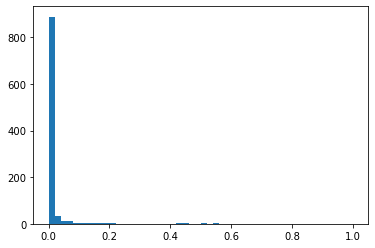

In [110]:
plt.hist(activations.mean(1),bins=50)

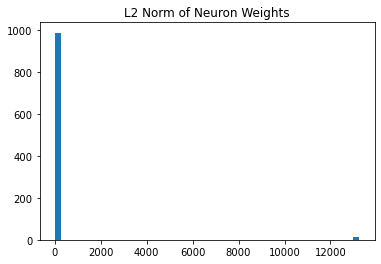

In [111]:
plt.figure()
plt.hist(torch.norm(og_weights, dim=1), bins=50)
plt.title("L2 Norm of Neuron Weights")
plt.show()

(array([986.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  13.]),
 array([2.7252526e+00, 2.6773361e+02, 5.3274200e+02, 7.9775037e+02,
        1.0627587e+03, 1.3277671e+03, 1.5927754e+03, 1.8577838e+03,
        2.1227922e+03, 2.3878005e+03, 2.6528088e+03, 2.9178174e+03,
        3.1828257e+03, 3.4478340e+03, 3.7128423e+03, 3.9778508e+03,
        4.2428589e+03, 4.5078677e+03, 4.7728760e+03, 5.0378843e+03,
        5.3028926e+03, 5.5679009e+03, 5.8329092e+03, 6.0979175e+03,
        6.3629263e+03, 6.6279346e+03, 6.8929429e+03, 7.1579512e+03,
        7.4229595e+03, 7.6879678e+03, 7.9529761e+03, 8.2179844e+03,
        8.4829932e+03, 8.7480010e+03, 9.0130098e+03, 9.2780176e+03,
        9.5430264e+03, 9.8080352e+03, 1.007304

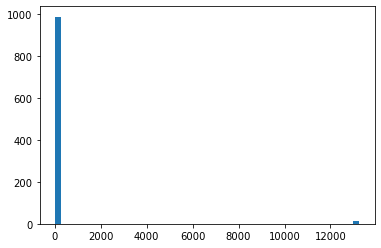

In [112]:
# there are 13 that are super large. the rest are very small. 
plt.hist(torch.norm(og_weights, dim=1), bins=50)

# Sanity checks

In [116]:
# Looking at how active each of the no L2 norm values actually are

run = 'z0unvxvg'

# add the og model to the list of models. 
src = f"../../scratch_link/Foundational-SDM/wandb_Logger/Foundational-SDM/{run}/checkpoints/*"
model_checkpoints = glob.glob(src)
ckpt = torch.load(model_checkpoints[0], map_location=device)
og_model_path = "../"+ckpt['hyper_parameters']['load_from_checkpoint']

print("===="*10)
print("Run is:", run)
print(ckpt['hyper_parameters']['test_name'], ckpt['hyper_parameters']['model_foundation'])
print("===="*10)

# sort the models. 
models_dict = {0:og_model_path}
for c in model_checkpoints:
    c_epoch = int(c.split('epoch=')[-1].split('-')[0])
    models_dict[c_epoch] = c
sorted_models = list(models_dict.keys())
sorted_models.sort()

# load in the original model weights
og_ckpt = torch.load(og_model_path, map_location=device)
og_params = og_ckpt['hyper_parameters']
og_params = SimpleNamespace(**og_params)
#og_params.dataset = DataSet.Cached_ConvMixer_ImageNet32
og_weights, og_out_weights = get_weights(og_ckpt, og_params)
og_out_weights = og_out_weights[:,:10]

# get the dataset that corresponds to one of the data splits by loading in the last model. 
# have the params from the split models too. 
model_path = models_dict[sorted_models[-1]]
ckpt = torch.load(model_path, map_location=device)
params = ckpt['hyper_parameters']
params = SimpleNamespace(**params)
last_model_weights, last_model_out_weights = get_weights(ckpt, params)

Run is: z0unvxvg
TopKDefault_Investigate_ContLearning <class 'models.FFN_TOP_K.FFN_TOP_K'>


In [117]:
data_module = LightningDataModule(
        params,
        data_path=dataset_path
    )
data_module.setup(None, train_shuffle=False, test_shuffle=False)

# sort the pickles. Needed to wait to load in parameters from above. 
act_pickles = glob.glob(f'../../scratch_link/Foundational-SDM/pickles/{params.test_name}_*')
pickles_dict = {}
for c in act_pickles:
    c_epoch = int(c.split('Learning_')[-1].split('_')[0])
    pickles_dict[c_epoch] = c
sorted_pickles = list(pickles_dict.keys())
sorted_pickles.sort()

all_data = torch.stack( [d.images for d in data_module.train_datasets]).flatten(end_dim=1)
all_labels = torch.stack( [d.img_labels for d in data_module.train_datasets]).flatten(end_dim=1)

# ensure that weights and data are L2 normed if it is SDM!
if "SDM" in str(params.model_foundation) and params.norm_addresses:
    all_data = all_data/torch.norm(all_data, dim=1, keepdim=True)

# looking at activations using the original weights not the final ones. 
activations = get_activations(all_data, og_model_path, og_params, extras) #get_activations(all_data,og_weights, ckpt)

../experiments/ConvMixer_ImageNet32_ImageNet32_ContLearnStarters/TopKDefault_ContinualLearningPretrains_ConvMixer_WTransforms_ImageNet32_ImageNet32 /home/tbb16/Foundational-SDM/notebooks


In [ ]:
activations[:,0]